In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

import pandas as pd
import pickle
from tqdm.notebook import tqdm
from plotnine import *
from mizani.palettes import brewer_pal
from palettable import colorbrewer
palette=brewer_pal(type='qual', palette='Set1')

from mcmcmd.samplers import *
from mcmcmd.tests import *

from statsmodels.tsa.stattools import acf
import joblib


In [2]:
class gandy_scott_sampler(model_sampler):
    def __init__(self, **kwargs):
        self._N = 1
        self._D = 1
        self._sigma = 10
        self._sigma_epsilon = onp.sqrt(0.1)
        super().__init__(**kwargs)
                     
        assert self._sigma > 0
        assert self._sigma_epsilon > 0
                     
        pass

    @property
    def sample_dim(self):
        return self._N + 2

    @property
    def theta_indices(self):
        return onp.arange(self._N, self.sample_dim)


    def drawPrior(self, rng=None):
        if rng is None:
            rng = self._rng_s

        self._theta_1 = rng.normal(loc=0, scale=self._sigma)
        self._theta_2 = rng.normal(loc=0, scale=self._sigma)
                     
        return onp.array([self._theta_1, self._theta_2])

    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = self._rng_s

        self._y = rng.normal(loc=self._theta_1 + self._theta_2,
                           scale=self._sigma_epsilon, size = (self._N, 1))
        
        return self._y.flatten()

    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

    def test_functions(self, samples):
        assert samples.shape[1] == self.sample_dim
        
        g = onp.hstack([samples[:, self.theta_indices[0]].reshape(-1,1), 
                       (samples[:, self.theta_indices[0]]**2).reshape(-1,1), 
                       (samples[:, self.theta_indices[0]]*samples[:, self.theta_indices[1]]).reshape(-1,1), 
                       onp.exp(scipy.stats.norm.logpdf(x=samples[:, self.theta_indices], scale=self._sigma).sum(1)).reshape(-1,1),
                       onp.exp(scipy.stats.norm.logpdf(x=(samples[:, :self._N]).reshape(-1,1), loc=(samples[:, self.theta_indices[0]]+samples[:, self.theta_indices[1]]).reshape(-1,1), scale=self._sigma_epsilon).sum(1)).reshape(-1,1)
                      ])
        return g
    
# Incorrect expectation
class gandy_scott_sampler_error_1(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y+self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y+self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y+self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y+self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

# Incorrect variance
class gandy_scott_sampler_error_2(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma + self._N/self._sigma_epsilon)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 

# Swap posterior means
class gandy_scott_sampler_error_3(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)
        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            self._theta_1 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            self._theta_2 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
            self._theta_2 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            self._theta_1 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
        
        return onp.array([self._theta_1, self._theta_2]) 
    
# Laplace in posterior instead of normal
class gandy_scott_sampler_error_4(gandy_scott_sampler):
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
                
        var_post = 1/(1/self._sigma**2 + self._N/self._sigma_epsilon**2)

        
        # Random scan for reversibility
        if rng.choice(2) == 1:
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
#             self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            self._theta_1 = rng.laplace(loc=exp_post_1, scale=onp.sqrt(var_post))
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
#             self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            self._theta_2 = rng.laplace(loc=exp_post_2, scale=onp.sqrt(var_post))
        else:
            exp_post_2 = var_post * ((self._y-self._theta_1).sum()/self._sigma_epsilon**2)
#             self._theta_2 = rng.normal(loc=exp_post_2, scale=onp.sqrt(var_post))
            self._theta_2 = rng.laplace(loc=exp_post_2, scale=onp.sqrt(var_post))
            exp_post_1 = var_post * ((self._y-self._theta_2).sum()/self._sigma_epsilon**2)
#             self._theta_1 = rng.normal(loc=exp_post_1, scale=onp.sqrt(var_post))
            self._theta_1 = rng.laplace(loc=exp_post_1, scale=onp.sqrt(var_post))
        return onp.array([self._theta_1, self._theta_2]) 

# Setup

The model is
\begin{align}
    y &= \theta_1 + \theta_2 + \epsilon \\
    \theta_i &\sim \mathcal{N}(0, \sigma^2), i=1,2 \\
    \epsilon &\sim \mathcal{N}(0, \sigma_\epsilon^2)
\end{align}

The posterior distributions of $\theta_1$ and $\theta_2$ are also normal

\begin{align}
\theta_{i} \sim \mathcal{N}(
\frac{\sigma^{2}}{\sigma_{\epsilon}^{2}+\sigma^{2}}\left(y-\theta_{j}\right)
, \frac{1}{\frac{1}{\sigma_{\epsilon}^{2}}+\frac{1}{\sigma^{2}}})
\end{align}

# Experiments

In [35]:
def exp_label(x):
    if 'sampler_error_3' in x:
        return 'Type II - Mean Swap'
    elif 'sampler_error_4' in x:
        return 'Type II - Laplace'
    else:
        return 'Type I'

# BC Tests

In [36]:
def run_trial(model, num_samples, bc_burn_in, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc = num_samples_mc_bc
    
    model.set_seed(seed)
    
    samples_mc = model.sample_mc(num_samples_mc)
    samples_bc = model.sample_bc(num_samples_bc, bc_burn_in)
    
#     data_mc = samples_mc[:, :model._N]
#     data_bc = samples_bc[:, :model._N]
    
    samples_mc = model.test_functions(samples_mc)
    samples_bc = model.test_functions(samples_bc)
    
    ## Rank
    test_functions_aux = lambda samples: model.test_functions(samples)[:, -2:]
    test_functions_theta = lambda samples: model.test_functions(samples)[:, :-2]
    rej_rank_aux = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1), test_functions=test_functions_aux)['result'].max()
    rej_rank_theta = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1), test_functions=test_functions_theta)['result'].max()
    rej_rank_auxtheta = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1))['result'].max()
        
    ## KS
    rej_ks_aux = ks_test(samples_mc[:, -2:], samples_bc[:, -2:])['result'].max()
    rej_ks_theta = ks_test(samples_mc[:, :-2], samples_bc[:, :-2])['result'].max()
    rej_ks_auxtheta = ks_test(samples_mc, samples_bc)['result'].max()
    
    ## MMD
    col_mmd = onp.hstack([onp.arange(len(model.theta_indices)),[-2, -1]])
    X_mmd = samples_mc[:, col_mmd]
    Y_mmd = samples_bc[:, col_mmd]
    
#     # Add data
#     X_mmd = onp.hstack([data_mc, X_mmd])
#     Y_mmd = onp.hstack([data_bc, Y_mmd])
    
    # Normalize scale
    X_mmd, Y_mmd = normalizeTwoSamples(X_mmd, Y_mmd)
    
    # Aux Linear
    rej_mmd_aux_linear = mmd_test(X_mmd[:, -2:], Y_mmd[:, -2:], linear_kernel, alpha=alpha, mmd_type='unbiased')['result']
    # Theta Linear
    rej_mmd_theta_linear = mmd_test(X_mmd[:, :-2], Y_mmd[:, :-2], linear_kernel, alpha=alpha, mmd_type='unbiased')['result']
    
    # Aux Nonlinear
    rej_mmd_aux_rbf = mmd_test(X_mmd[:, -2:], Y_mmd[:, -2:], rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']
    # Theta Nonlinear
    rej_mmd_theta_rbf = mmd_test(X_mmd[:, :-2], Y_mmd[:, :-2], rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']
    
    # Aux & Theta
    rej_mmd_auxtheta_linear = mmd_test(X_mmd, Y_mmd, linear_kernel, alpha=alpha, mmd_type='unbiased')['result']
    rej_mmd_auxtheta_rbf = mmd_test(X_mmd, Y_mmd, rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']
    
    return onp.array([rej_mmd_aux_linear, rej_mmd_theta_linear, rej_mmd_auxtheta_linear, rej_mmd_aux_rbf, rej_mmd_theta_rbf, rej_mmd_auxtheta_rbf, 
                      rej_ks_aux, rej_ks_theta, rej_ks_auxtheta, rej_rank_aux, rej_rank_theta, rej_rank_auxtheta])

In [38]:
os.environ['MKL_NUM_THREAD'] = '1'

num_trials = 100
alpha = 0.05

bc_burn_in = 5-1

lst_experiments = [gandy_scott_sampler(), gandy_scott_sampler_error_3(), gandy_scott_sampler_error_4()]
lst_sample_budget = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

lst_res = []

with joblib.Parallel(n_jobs=5) as para:
    for model in tqdm(lst_experiments):
        for n in tqdm(lst_sample_budget):
            num_samples_bc = int(1/(bc_burn_in+2) * n)
            test_size_bc = num_samples_bc

            results = para(joblib.delayed(run_trial)(model, n, bc_burn_in, alpha, seed) for seed in range(num_trials))
            results = onp.vstack(results).mean(0)

            # Convert rejection rate to Type I/II error
            if 'error' in type(model).__name__:
                results = 1-results

            lst_inputs = ['aux', 'theta', 'aux, theta']*4
            lst_test = ['mmd']*6 + ['ks']*3 + ['rank']*3
            lst_kernel = ['linear']*3 + ['rbf']*3 + [None]*3 + [None]*3
            lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'test':lst_test, 'inputs':lst_inputs, 'kernel':lst_kernel, 'test_size':test_size_bc, 'sample_budget':n, 'result':results}))

In [39]:
df_results = pd.concat(lst_res)
df_results.loc[df_results.kernel.isnull(), 'kernel'] = 'linear'
df_results['test_size'] = pd.to_numeric(df_results['test_size'])
df_results['sample_budget'] = pd.to_numeric(df_results['sample_budget'])
df_results['result'] = pd.to_numeric(df_results['result'])

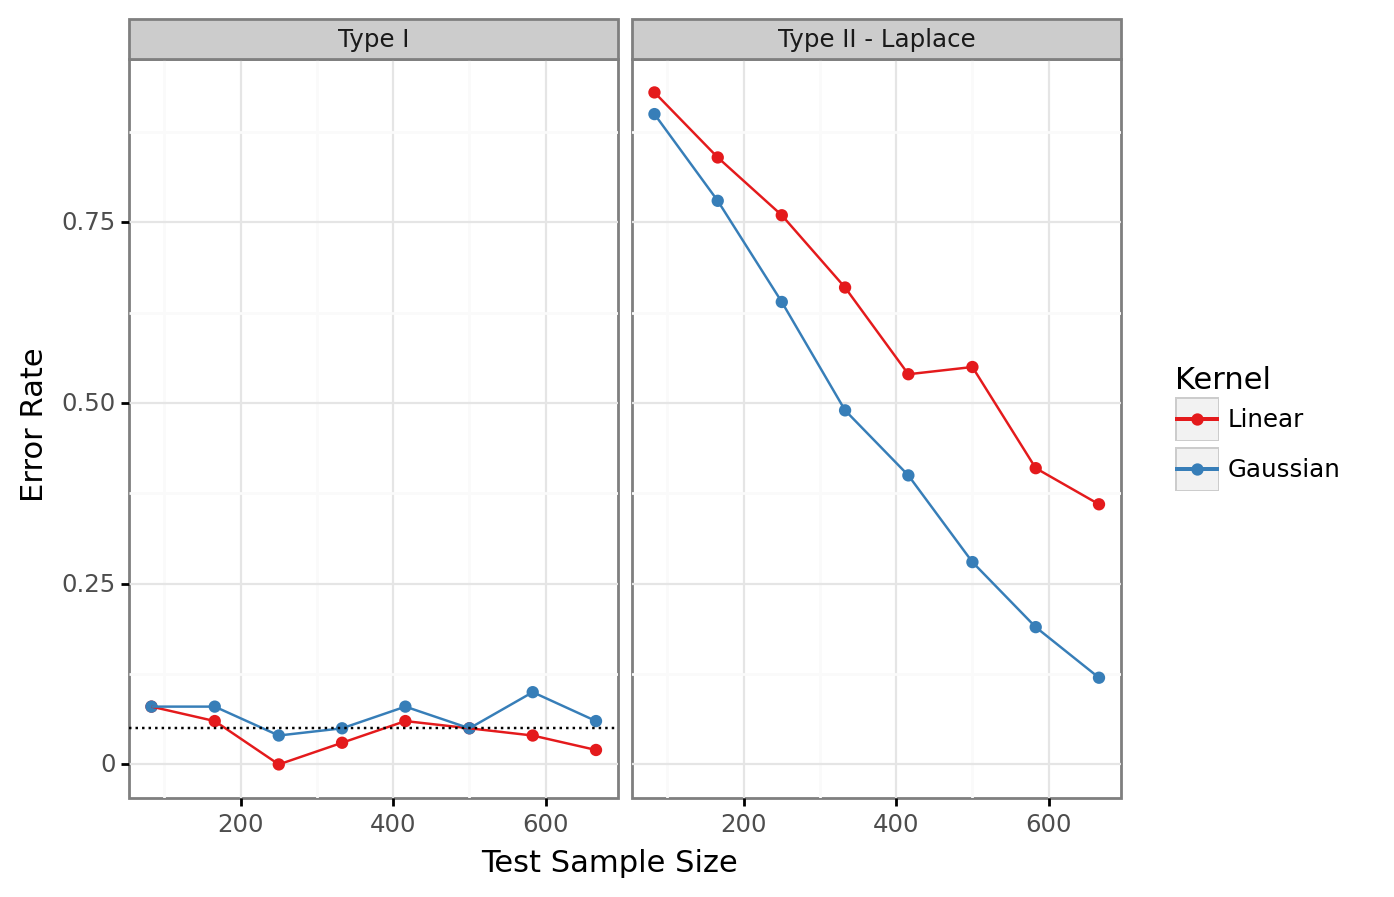

<ggplot: (8775341117898)>

In [40]:
# df_results=pd.read_pickle('gandy_scott_bc')

# Nonlinear vs linear kernel
df_hline = pd.DataFrame({'experiment':['gandy_scott_sampler'], 'alpha':[alpha]})
mask = df_results.test.str.contains('mmd') & df_results.inputs.str.contains('aux, theta') & ~df_results.experiment.str.contains('3')
plot_kernel=ggplot(df_results.loc[mask], aes(x='test_size', y='result', color='kernel')) + \
        geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') +  \
        facet_grid('~experiment', labeller=exp_label) + \
        labs(x='Test Sample Size', y='Error Rate', color='Kernel') + \
        scale_color_discrete(labels=['Linear', 'Gaussian'], palette=palette) + theme_bw()
plot_kernel

In [42]:
ggsave(plot_kernel, 'gandy_scott_kernel')

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: gandy_scott_kernel


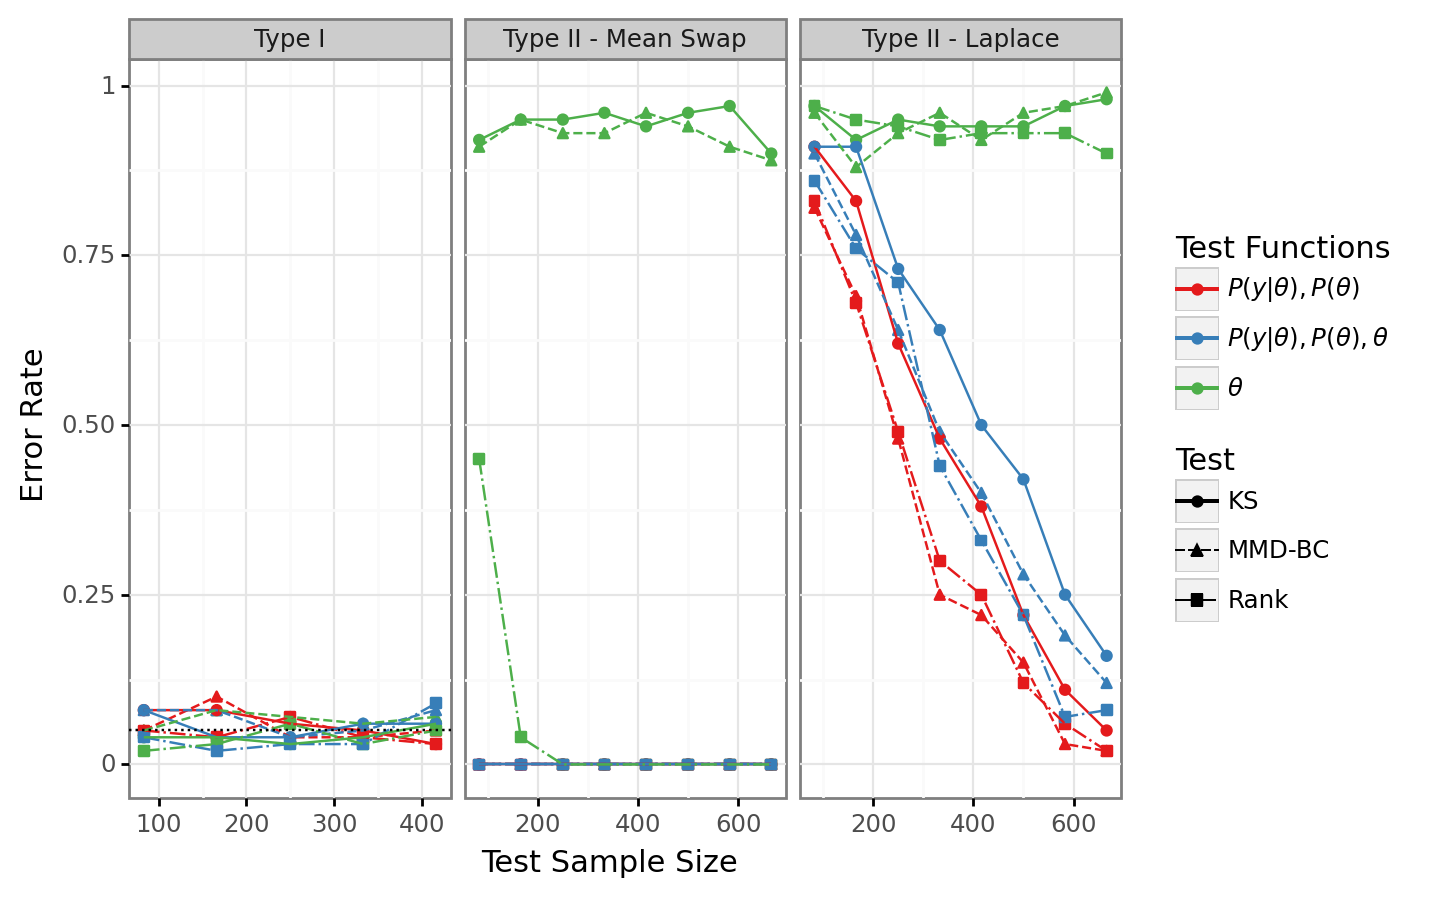

<ggplot: (8775466667915)>

In [41]:
# df_results=pd.read_pickle('gandy_scott_bc')

# Value of Aux
df_hline = pd.DataFrame({'experiment':['gandy_scott_sampler'], 'alpha':[alpha]})
mask = ~((df_results.test == 'mmd') & (df_results.kernel == 'linear')) & ~((df_results.experiment == 'gandy_scott_sampler') & (df_results.test_size>450))
plot_aux=ggplot(df_results.loc[mask], aes(x='test_size', y='result', color='inputs', linetype='test', shape = 'test')) + \
        geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') +  \
        facet_wrap('~experiment', labeller=exp_label, scales='free_x') + \
        labs(x='Test Sample Size', y='Error Rate', color='Test Functions', linetype='Test', shape='Test') + \
        scale_color_discrete(labels=[r'$P(y|\theta), P(\theta)$', r'$P(y|\theta), P(\theta), \theta$', r'$\theta$'], palette=palette) + \
        scale_linetype_discrete(labels=['KS', 'MMD-BC', 'Rank']) + scale_shape_discrete(labels=['KS', 'MMD-BC', 'Rank']) + \
        theme_bw()
plot_aux

In [43]:
ggsave(plot_aux, 'gandy_scott_aux')

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: gandy_scott_aux


Performance vs autocorrelation. Increasing $\sigma_\epsilon$ decreases autocorrelation.

In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

import pandas as pd
import pickle
from tqdm.notebook import tqdm
from plotnine import *

from mcmcmd.samplers import *
from mcmcmd.tests import *

from statsmodels.tsa.stattools import acf
import joblib

In [ ]:
def run_trial(model, num_samples, bc_burn_in, sc_thinning, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    sc_thinning = int(sc_thinning)
    
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    num_samples_sc = int((sc_thinning)/(sc_thinning+1) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc_sc = num_samples-num_samples_sc
    num_samples_mc = max(num_samples_mc_bc, num_samples_mc_sc)
    
    model.set_seed(seed)
    samples_mc = model.test_functions(model.sample_mc(num_samples_mc))
    samples_sc = model.test_functions(model.sample_sc(num_samples_sc))[onp.arange(0, num_samples_sc, sc_thinning), :]
    samples_bc = model.test_functions(model.sample_bc(num_samples_bc, bc_burn_in))
    
    rej_ks = ks_test(samples_mc[:num_samples_bc, :], samples_bc)['result'].max()
    
    rej_geweke = geweke_test(samples_mc[:(num_samples-num_samples_sc), :], samples_sc, l=0.08, alpha=alpha)['result'].max()
    
    # Normalize for MMD
    col_mmd = onp.hstack([onp.arange(len(model.theta_indices)),[-2, -1]])
    X_mmd_wb, Y_mmd_wb = normalizeTwoSamples(samples_mc[:(num_samples-num_samples_sc), :][:, col_mmd], samples_sc[:, col_mmd])
    X_mmd, Y_mmd = normalizeTwoSamples(samples_mc[:num_samples_bc, :][:, col_mmd], samples_bc[:, col_mmd])
    
    
    rej_mmd = mmd_test(X_mmd, Y_mmd, rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']        
    rej_mmd_wb = mmd_wb_test(X_mmd_wb, Y_mmd_wb, rbf_kernel, alpha=alpha)['result']
    
#     col_theta = onp.arange(len(model.theta_indices))
#     rej_mmd_theta = mmd_test(X_mmd[:, col_theta], Y_mmd[:, col_theta], rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']
#     rej_mmd_wb_theta = mmd_wb_test(X_mmd_wb[:, col_theta], Y_mmd_wb[:, col_theta], rbf_kernel, alpha=alpha)['result']
    
    rej_rank = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1))['result'].max()

    return onp.array([rej_ks, rej_geweke, rej_mmd_wb, rej_mmd, rej_rank])

In [ ]:
os.environ['MKL_NUM_THREAD'] = '1'

num_trials = 100
alpha = 0.05

# Same amount of effort
bc_burn_in = 5-1
sc_thinning = 5

lst_std = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
lst_experiments = [gandy_scott_sampler(sigma_epsilon=x) for x in lst_std] + \
                    [gandy_scott_sampler_error_4(sigma_epsilon=x) for x in lst_std]
lst_sample_size = [1800]

lst_res = []

with joblib.Parallel(n_jobs=5) as para:
    for model in tqdm(lst_experiments):
        for n in tqdm(lst_sample_size):
            num_samples_bc = int(1/(bc_burn_in+2) * n)
            num_samples_sc = int((sc_thinning)/(sc_thinning+1) * n)
            test_size_bc = num_samples_bc
            test_size_sc = n-num_samples_sc

            results = para(joblib.delayed(run_trial)(model, n, bc_burn_in, sc_thinning, alpha, seed) for seed in range(num_trials))
            results = onp.vstack(results).mean(0)

           # Convert rejection rate to Type I/II error
            if 'error' in type(model).__name__:
                results = 1-results

            lst_test = ['ks', 'geweke', 'mmd_wb', 'mmd', 'rank']
            lst_test_size = [test_size_bc, test_size_sc, test_size_sc, test_size_bc, test_size_bc]
            lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'sigma_epsilon':model._sigma_epsilon, 'test':lst_test,  'test_size':lst_test_size, 'sample_budget':n, 'result':results}))

In [ ]:
df_results = pd.concat(lst_res)
df_results['test_size'] = pd.to_numeric(df_results['test_size'])
df_results['sample_budget'] = pd.to_numeric(df_results['sample_budget'])
df_results['result'] = pd.to_numeric(df_results['result'])

In [ ]:
df_results.loc[df_results.test.str.contains('geweke|mmd_wb'), 'posterior_sampler'] = 'SC'
df_results.loc[~df_results.test.str.contains('geweke|mmd_wb'), 'posterior_sampler'] = 'BC'

In [ ]:
# df_results=pd.read_pickle('gandy_scott_auto')

df_hline = pd.DataFrame({'experiment':['gandy_scott_sampler'], 'alpha':[alpha]})
mask = ~(df_results.test.str.contains('rank'))

plot_auto = ggplot(df_results.loc[mask], aes(color='test', group='test', x='sigma_epsilon',  y='result', linetype='posterior_sampler')) + \
    geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') + \
    facet_grid('~experiment', labeller = exp_label) + \
    labs(x=r'$\sigma_{\epsilon}$', y='Error Rate', color='Test', linetype='Test Class') + \
    scale_color_discrete(labels=['Geweke', 'KS', 'MMD-BC', 'MMD-SC'], palette=palette) + \
    scale_linetype_discrete(labels=['BC', 'SC']) + theme_bw()

plot_auto

In [ ]:
ggsave(plot_auto, 'gandy_scott_auto')

# Joint / Joint Product / Joint Sum Kernels

In [ ]:
def run_trial(model, num_samples, bc_burn_in, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc = num_samples_mc_bc
    
    model.set_seed(seed)
    
    X_mmd = model.sample_mc(num_samples_mc)
    Y_mmd = model.sample_bc(num_samples_bc, bc_burn_in)

    rej_mmd_joint_prod = mmd_test(X_mmd, Y_mmd, prod_kernel, alpha=alpha, mmd_type='unbiased', 
                                  lst_classes=[rbf_kernel, rbf_kernel], lst_groups=[onp.arange(model._N), model.theta_indices])['result']

    rej_mmd_joint_sum = mmd_test(X_mmd, Y_mmd, sum_kernel, alpha=alpha, mmd_type='unbiased', 
                                  lst_classes=[rbf_kernel, rbf_kernel], lst_groups=[onp.arange(model._N), model.theta_indices])['result']
    
    X_mmd, Y_mmd = normalizeTwoSamples(X_mmd, Y_mmd)
    rej_mmd_joint = mmd_test(X_mmd, Y_mmd, rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']
    
    return onp.array([rej_mmd_joint, rej_mmd_joint_prod, rej_mmd_joint_sum])

In [ ]:
os.environ['MKL_NUM_THREAD'] = '1'

num_trials = 100
alpha = 0.05

bc_burn_in = 5-1

lst_experiments = [gandy_scott_sampler(), gandy_scott_sampler_error_3(), gandy_scott_sampler_error_4()]
lst_sample_budget = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

lst_res = []

with joblib.Parallel(n_jobs=5) as para:
    for model in tqdm(lst_experiments):
        for n in tqdm(lst_sample_budget):
            num_samples_bc = int(1/(bc_burn_in+2) * n)
            test_size_bc = num_samples_bc

            results = para(joblib.delayed(run_trial)(model, n, bc_burn_in, alpha, seed) for seed in range(num_trials))
            results = onp.vstack(results).mean(0)

            # Convert rejection rate to Type I/II error
            if 'error' in type(model).__name__:
                results = 1-results

            lst_inputs = ['aux, theta']*3
            lst_test = ['mmd']*3
            lst_kernel = ['rbf', 'rbf_prod', 'rbf_sum']
            lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'test':lst_test, 'inputs':lst_inputs, 'kernel':lst_kernel, 'test_size':test_size_bc, 'sample_budget':n, 'result':results}))

In [ ]:
df_results=pd.concat(lst_res)
df_hline = pd.DataFrame({'experiment':['gandy_scott_sampler'], 'alpha':[alpha]})
plot_jps=ggplot(df_results, aes(x='test_size', y='result', color='kernel')) + \
        geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') +  \
        facet_grid('~experiment', labeller=exp_label) + \
        labs(x='Test Sample Size', y='Error Rate', color='Kernel') + \
        scale_color_discrete(labels=['Joint', 'Product', 'Sum'], palette=palette) + theme_bw()
plot_jps